# Практическое задание к уроку "CNN. Детектирование"

Домашнее задание:
Используя файл Web2.ipynb (он в полезных ссылках):

Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection

*Нужно будет произвести аугментацию данных

Затем обучить нейронную сеть на получившемся датасете

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

DATA_FOLDER_PATH = '../data'
IMAGES_PATH = os.path.join(DATA_FOLDER_PATH, 'images')
ANNOTATION_PATH = os.path.join(DATA_FOLDER_PATH, 'annotations')

### Загрузим данные в DataFrame

In [2]:
from pathlib import Path
import xml.etree.ElementTree as ET

def generate_train_df (anno_path):
    annotations = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(anno_path)]
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(IMAGES_PATH) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
#        anno['depth'] = root.find("./size/depth").text
#        anno['segmented'] = root.find("./segmented").text
        anno['class'] = root.find("./object/name").text
#        anno['truncated'] = root.find("./object/truncated").text
#        anno['occluded'] = root.find("./object/occluded").text
#        anno['difficult'] = root.find("./object/difficult").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(ANNOTATION_PATH)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../data/images/Cats_Test2531.png,500,333,dog,10,5,457,305
1,../data/images/Cats_Test1038.png,375,500,cat,102,15,272,204
2,../data/images/Cats_Test134.png,300,225,dog,84,31,216,171
3,../data/images/Cats_Test1986.png,375,500,dog,160,59,256,179
4,../data/images/Cats_Test652.png,500,332,cat,250,40,486,242
...,...,...,...,...,...,...,...,...
3681,../data/images/Cats_Test1747.png,500,375,cat,227,55,303,149
3682,../data/images/Cats_Test893.png,375,500,dog,145,135,277,307
3683,../data/images/Cats_Test1021.png,400,267,cat,86,28,306,258
3684,../data/images/Cats_Test2528.png,375,500,cat,103,238,267,425


### Посмотрим состав классов для классификации

In [4]:
df_train['class'].value_counts()

dog    2498
cat    1188
Name: class, dtype: int64

### Заменим классы на числа

In [5]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,../data/images/Cats_Test2531.png,500,333,1,10,5,457,305
1,../data/images/Cats_Test1038.png,375,500,0,102,15,272,204
2,../data/images/Cats_Test134.png,300,225,1,84,31,216,171
3,../data/images/Cats_Test1986.png,375,500,1,160,59,256,179
4,../data/images/Cats_Test652.png,500,332,0,250,40,486,242


### Объявим функции создания маски для bounding box с учетом ресайза картинок

In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [7]:
IM_SIZE = 300

In [8]:
from pathlib import Path

new_paths = []
new_bbs = []
train_path_resized = Path('../data/images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../data/images/Cats_Test2531.png,500,333,1,10,5,457,305,../data/images_resized/Cats_Test2531.png,"[4.0, 6.0, 274.0, 273.0]"
1,../data/images/Cats_Test1038.png,375,500,0,102,15,272,204,../data/images_resized/Cats_Test1038.png,"[9.0, 81.0, 122.0, 217.0]"
2,../data/images/Cats_Test134.png,300,225,1,84,31,216,171,../data/images_resized/Cats_Test134.png,"[41.0, 84.0, 228.0, 215.0]"
3,../data/images/Cats_Test1986.png,375,500,1,160,59,256,179,../data/images_resized/Cats_Test1986.png,"[35.0, 128.0, 107.0, 204.0]"
4,../data/images/Cats_Test652.png,500,332,0,250,40,486,242,../data/images_resized/Cats_Test652.png,"[36.0, 150.0, 218.0, 291.0]"


(500, 333, 3) [ 76  86 314 304]


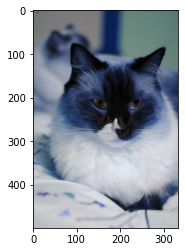

In [9]:
from matplotlib import pyplot as plt

IMAGE_INDEX = 15

im = cv2.imread(str(df_train.values[IMAGE_INDEX][0]))
bb = create_bb_array(df_train.values[IMAGE_INDEX])
print(im.shape, bb)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

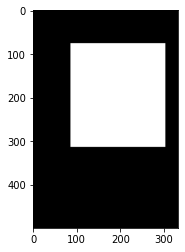

In [10]:
plt.imshow(Y, cmap='gray')

In [11]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

../data/images_resized/Cats_Test2069.png


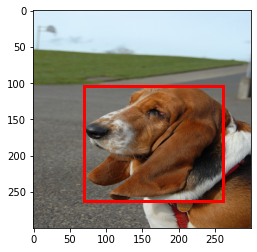

In [12]:
number = 45
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

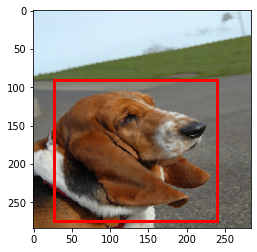

In [13]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

### Оформим dataset pytorch

Сделаем разбиение на train и validation выборки

In [14]:
from sklearn.model_selection import train_test_split

df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Создадим тестовый и валидационный датасеты pytorch

In [15]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class AnimalsDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = AnimalsDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = AnimalsDataset(X_val['new_path'], X_val['new_bb'], y_val)

Загрузим в DataLoader

In [16]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

Используем предобученный resNet-34

In [17]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [18]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [19]:
model = BB_model() # .cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 15
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [49]:
from torch import tensor

def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            y_class = tensor(np.array(list(y_class)))
            len_batch = y_class.shape[0]
            x = x.float() #.cuda().float()
            # y_class = y_class #.cuda()
            y_bb = y_bb.float() #.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            y_class = tensor(np.array(list(y_class)))
            len_batch = y_class.shape[0]
            x = x.float() # cuda().float()
            # y_class = y_class # .cuda()
            y_bb = y_bb.float() # cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [50]:
train()

Epoch [1/15]. train_loss 238.582 val_loss 492.906 val_acc 0.229
Epoch [2/15]. train_loss 141.442 val_loss 138.635 val_acc 0.687
Epoch [3/15]. train_loss 141.243 val_loss 147.998 val_acc 0.687
Epoch [4/15]. train_loss 140.790 val_loss 137.201 val_acc 0.687
Epoch [5/15]. train_loss 140.415 val_loss 143.954 val_acc 0.543
Epoch [6/15]. train_loss 141.359 val_loss 144.097 val_acc 0.687
Epoch [7/15]. train_loss 140.600 val_loss 140.207 val_acc 0.687
Epoch [8/15]. train_loss 139.163 val_loss 141.035 val_acc 0.687
Epoch [9/15]. train_loss 137.779 val_loss 132.275 val_acc 0.684
Epoch [10/15]. train_loss 136.064 val_loss 136.949 val_acc 0.673
Epoch [11/15]. train_loss 134.131 val_loss 128.947 val_acc 0.687
Epoch [12/15]. train_loss 133.820 val_loss 133.757 val_acc 0.687
Epoch [13/15]. train_loss 128.656 val_loss 121.559 val_acc 0.683
Epoch [14/15]. train_loss 123.065 val_loss 119.777 val_acc 0.676
Epoch [15/15]. train_loss 118.744 val_loss 122.146 val_acc 0.686


In [55]:
torch.save(model.state_dict(), '../model')

In [56]:
# resizing test image
im = read_image('../data/images_resized/Cats_Test0.png')
Path.mkdir(Path('../data/animals_test'), exist_ok=True)
cv2.imwrite('../data/animals_test/Cats_Test0.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [58]:
# test Dataset
test_ds = AnimalsDataset(
    pd.DataFrame([{'path':'../data/animals_test/Cats_Test0.png'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [59]:
# prediction
out_class, out_bb = model(xx)
out_class, out_bb

(tensor([[ 0.8469,  1.4336, -8.2341, -8.8394]], grad_fn=<AddmmBackward>),
 tensor([[ 29.0986, 114.9032, 115.6988, 215.5246]], grad_fn=<AddmmBackward>))

In [60]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1.4336], grad_fn=<MaxBackward0>),
indices=tensor([1]))

In [65]:
class_dict

{'cat': 0, 'dog': 1}

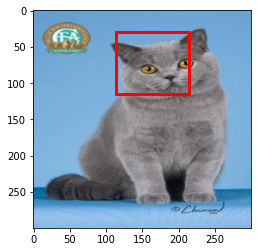

In [66]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])